<a href="https://colab.research.google.com/github/HanbumKo/DRL-course/blob/main/2_DQN/2_1_DQN_CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DQN**

이번 노트북에서는 CartPole 환경에서 DQN을 구현해보겠습니다.

In [1]:
"""
Reference
https://github.com/higgsfield/RL-Adventure/blob/master/1.dqn.ipynb
"""

'\nReference\nhttps://github.com/higgsfield/RL-Adventure/blob/master/1.dqn.ipynb\n'

구현에 필요한 라이브러리들을 import 합니다.

In [2]:
import gym
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

jupyter notebook에서 matplotlib을 사용하기 위해 필요한 함수도 import합니다.

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# Replay Buffer

Replay Buffer로 사용할 클래스입니다. store() 함수를 통해 (S, A, R, S', done)을 저장하며,sample_batch()를 통해 batch size만큼 history를 dictionary로 불러옵니다.

In [4]:
class ReplayBuffer:
    """
    https://github.com/openai/spinningup/blob/master/spinup/algos/pytorch/ddpg/ddpg.py
    """
    def __init__(self, obs_shape, act_shape, buffer_size):
        buffer_obs_shape = tuple([buffer_size]) + obs_shape
        buffer_act_shape = tuple([buffer_size]) + act_shape
        self.obs_buf = np.zeros(buffer_obs_shape, dtype=np.float32)
        self.obs2_buf = np.zeros(buffer_obs_shape, dtype=np.float32)
        self.act_buf = np.zeros(buffer_act_shape, dtype=np.float32)
        self.rew_buf = np.zeros(buffer_size, dtype=np.float32)
        self.done_buf = np.zeros(buffer_size, dtype=np.float32)
        self.pointer, self.size, self.buffer_size = 0, 0, buffer_size

    def store(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.pointer] = obs
        self.obs2_buf[self.pointer] = next_obs
        self.act_buf[self.pointer] = act
        self.rew_buf[self.pointer] = rew
        self.done_buf[self.pointer] = done
        self.pointer = (self.pointer+1) % self.buffer_size
        self.size = min(self.size+1, self.buffer_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(obs=self.obs_buf[idxs],
                     obs2=self.obs2_buf[idxs],
                     act=self.act_buf[idxs],
                     rew=self.rew_buf[idxs],
                     done=self.done_buf[idxs])
        return {k: torch.as_tensor(v, dtype=torch.float32) for k,v in batch.items()}

    def __len__(self):
        return self.size

# Model

Q network로 사용할 뉴럴넷 모델입니다. 이전 시간의 DAgger와 마찬가지로 CartPole에서는 (4 -> 64 -> 128 -> 2)의 구조를 사용합니다.

get_action() 함수를 통해 환경에 들어가는 int형의 action을 받을 수 있으며 get_output() 함수를 통해 model의 output을 받을 수 있습니다.

In [5]:
class DQNCartpole(nn.Module):
    def __init__(self, obs_dim, n_actions, device):
        super(DQNCartpole, self).__init__()

        self.obs_dim = obs_dim
        self.n_actions = n_actions
        self.device = device

        self.l1 = nn.Linear(obs_dim, 64)
        self.l2 = nn.Linear(64, 128)
        self.l3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)

        return x

    def get_action(self, obs, epsilon=0):
        if isinstance(obs, np.ndarray):
            obs = torch.tensor(obs, dtype=torch.float32)
        obs = obs.to(self.device)
        if random.random() > epsilon:
            with torch.no_grad():
                q = self.forward(obs)
                action = torch.argmax(q).item()
        else:
            action = random.randrange(self.n_actions)

        return action

    def get_output(self, obs, need_grad=True):
        if isinstance(obs, np.ndarray):
            obs = torch.tensor(obs, dtype=torch.float32)
        obs = obs.to(self.device)
        if need_grad:
            output = self.forward(obs)
        else:
            with torch.no_grad():
                output = self.forward(obs)

        return output.cpu()

# Test

모델과 환경을 파라미터로 받아 한 에피소드를 테스트하는 함수입니다. 에피소드의 리워드를 구하여 반환해줍니다.

In [6]:
def test(q_model, env):
    test_episode_reward = 0
    obs = env.reset()
    while True:
        action = q_model.get_action(obs, 0)
        next_obs, rew, done, _ = env.step(action)
        test_episode_reward += rew
        obs = next_obs
        if done:
            break

    return test_episode_reward

# Train

Replay Buffer에서 가져온 batch data로 모델을 업데이트 하는 함수입니다. target q value와 q value 사이의 TD error를 반환합니다.

In [7]:
def train(q_model, target_q_model, batch, optim, gamma):
    obs = batch["obs"].to(device)
    next_obs = batch["obs2"].to(device)
    act = torch.tensor(batch["act"], dtype=torch.int64).to(device)
    rew = batch["rew"].to(device)
    done = batch["done"].to(device)

    obs_output = q_model(obs)
    q = torch.gather(obs_output, 1, act).squeeze(1)

    with torch.no_grad():
        next_obs_output = target_q_model(next_obs)
        next_q = torch.max(next_obs_output, dim=1)[0]

    td_target = rew + gamma * next_q * (1-done)
    td_error = (q - td_target).pow(2).mean()

    optim.zero_grad()
    td_error.backward()
    optim.step()

    return td_error.item()

# Matplotlib

Matploblib을 이용해 테스트 reward와 TD error를 그래프로 보여주는 함수입니다.

In [8]:
def plot(test_rewards, td_errors):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('test reward')
    plt.plot(test_rewards)
    plt.subplot(132)
    plt.title('TD error')
    plt.plot(td_errors)
    plt.show()

# Main

트레이닝에 필요한 환경, 모델, loss, optimizer 등등을 정의하는 코드입니다. target q model은 q model과 같아지도록 복사해줍니다.

In [9]:
# Save device (cpu or cuda)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Make env
env = gym.make("CartPole-v0")

# shape
obs_shape = env.observation_space.shape
act_shape = tuple([1]) # int to Tuple
obs_dim = obs_shape[0]
n_actions = env.action_space.n
buffer_size = 1000

# Define NN
q_model = DQNCartpole(obs_dim=obs_dim, n_actions=n_actions, device=device)
target_q_model = DQNCartpole(obs_dim=obs_dim, n_actions=n_actions, device=device)
q_model.to(device)
target_q_model.to(device)

# Copy weight
target_q_model.load_state_dict(q_model.state_dict())

# Buffer & optimizer
replay_buffer = ReplayBuffer(obs_shape, act_shape, buffer_size)
optimizer = optim.Adam(q_model.parameters())

# training parameters
total_step = 10000
batch_size = 32
gamma = 0.99
epsilon = 0.05
copy_freq = 200

# lists for saving results
test_rewards = []
td_errors = []

DQN 트레이닝을 실행하는 메인 루프입니다. total_step만큼 돌면서 매 스텝마다 (S, A, R, S', done)을 Replay Buffer에 넣어주고 batch size 이상이 되면 불러와 한 번 웨이트를 업데이트 실행합니다. 매 50스텝 마다 테스트를 실행하며 200 스텝마다 target q model을 업데이트 해줍니다.

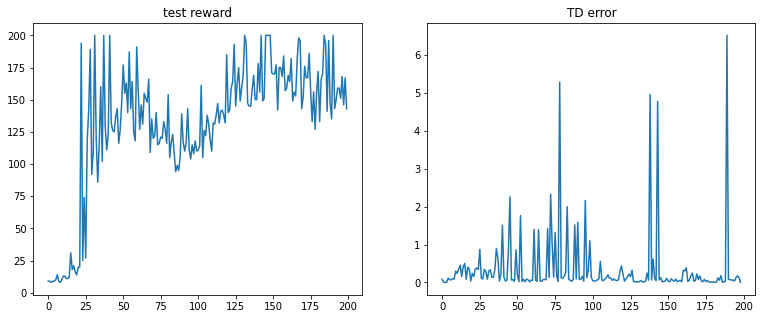

In [10]:
episode_reward = 0
best_test_reward = -999999
obs = env.reset()
for t in range(total_step):
    action = q_model.get_action(obs, epsilon)
    next_obs, rew, done, _ = env.step(action)
    replay_buffer.store(obs, action, rew, next_obs, done)
    episode_reward += rew
    obs = next_obs

    if done:
        # print("episode_reward :", episode_reward)
        obs = env.reset()
        episode_reward = 0

    # Train
    if len(replay_buffer) > batch_size:
        sampled_batch = replay_buffer.sample_batch(batch_size=batch_size)
        td_error = train(q_model, target_q_model, sampled_batch, optimizer, gamma)
        if t % 50 == 0:
            td_errors.append(td_error)
    
    # Test
    if t % 50 == 0:
        test_reward = test(q_model, gym.make("CartPole-v0"))
        test_rewards.append(test_reward)
        plot(test_rewards, td_errors)
        # print("test reward :", test_reward)
        if best_test_reward <= test_reward:
            # print("saved")
            best_test_reward = test_reward
            torch.save(q_model.state_dict(), "q_model.pt")
            torch.save(target_q_model.state_dict(), "target_q_model.pt")

    if t % copy_freq == 0:
        target_q_model.load_state_dict(q_model.state_dict())